# Checking_GPU_Availabilty

In [1]:
import torch
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650'

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## CMD Tensorboard

### tensorboard --logdir="C:\Users\User\OneDrive - University College London\UCL Education\Year 4\MLS\Coursework\AMLS_assignment24_25\Task A\runs\DisplayImage"

# Library imports, data loading and visualisation


In [133]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import medmnist
from medmnist import BreastMNIST
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import os
import shutil

import os
from tensorboard import program

import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
from torch import optim  # For optimizers like SGD, Adam, etc.
from tqdm import tqdm  # For nice progress bar!
import torchvision.datasets as datasets  # Standard datasets

## Loading datatsets from BreastMNIST

In [ ]:
transform = transforms.Compose([
    transforms.RandomAdjustSharpness(p=1,sharpness_factor=1.1),
    transforms.RandomEqualize(p=0.3),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))  # Mean and standard deviation for grayscale images
])
#Cannot blindly augment the data to what we want
#the classifiers depend on the chape of the tumer hence all the below is good
#Might consider increaasing the contrast and brightness to allow easier identificationn
#CANCEL contrast... USE histogram equaliser instetad
transforms.RandomVerticalFlip()
transforms.RandomHorizontalFlip()
transforms.RandomRotation(degrees=180)
transforms.RandomEqualize(p=1)
transforms.RandomAdjustSharpness(p=1,sharpness_factor=2)

RandomAdjustSharpness(sharpness_factor=2,p=1)

In [221]:
batch_size=32
#loading train,val,test into variables
train_data=medmnist.BreastMNIST(split="train",transform=transform)
val_data=medmnist.BreastMNIST(split="val",transform=transforms.ToTensor())
test_data=medmnist.BreastMNIST(split="test",transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)


# Data augmentation and class balancing

In [224]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from collections import Counter



# Instantiate the dataset
dataset = medmnist.BreastMNIST(split="train",transform=transform)

# Count class occurrences
class_counts = Counter(dataset.labels.reshape(-1))
print(f"Class distribution before oversampling: {class_counts}")

# Compute sample weights: Inverse of class frequencies
class_weights = 1.0 / torch.tensor([class_counts[cls] for cls in sorted(class_counts.keys())], dtype=torch.float)
sample_weights = torch.tensor([class_weights[label] for label in dataset.labels.reshape(-1)], dtype=torch.float)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoader with sampler
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)
train_data=dataloader
# Check the distribution of classes in a few batches
for batch_idx, (data, labels) in enumerate(dataloader):
    print(f"Batch {batch_idx+1} class distribution: {Counter(labels.reshape(-1).tolist())}")
    if batch_idx == 2:  # Check only the first 3 batches
        break

# Initialize a Counter for tracking class counts
total_class_counts = Counter()

# Iterate through the entire dataloader
for data, labels in dataloader:
    # Flatten the labels and convert them to a list
    total_class_counts.update(labels.reshape(-1).tolist())

# Print the total distribution of classes
print(f"Total class distribution in the dataloader: {total_class_counts}")
print(len(dataloader)*32)

Class distribution before oversampling: Counter({1: 399, 0: 147})
Batch 1 class distribution: Counter({0: 17, 1: 15})
Batch 2 class distribution: Counter({0: 17, 1: 15})
Batch 3 class distribution: Counter({0: 19, 1: 13})
Total class distribution in the dataloader: Counter({1: 299, 0: 247})
576


In [87]:
data, labels=next(iter(train_loader))
x=labels.view(-1)
x=x.tolist()
print(x)
Counter(x)

[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]


Counter({1: 52, 0: 12})

# Loading Example mnist dataset

In [8]:
# Hyperparameters
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 5

# Load Data
train_dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.MNIST(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Debugging and testing

In [8]:

# print(train_data)
# print("=====================")
# print(val_data)
# print("=====================")
# print(test_data)

for i, (images, labels) in enumerate(train_loader):
    print(images.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 2

In [43]:
#visualising the size of the image and its labels
one=0
zero=0
for image , label in train_data:
    # print(image.shape)
    # print(label)
    if label==0:
        zero+=1
    else:
        one+=1
print(one)
print(zero)

399
147


### Displaying images on Tensorboard

In [11]:
#location of tensorboard folder
folder="runs/DisplayImage"

In [164]:
clear_folder(folder)
#show using dataset on tensorboard
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
writer = SummaryWriter(f"runs/DisplayImage")
for index in range(100):
    data,label=train_data[index]
    writer.add_image("mnist_images", data,index)
    
writer.close()

Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Train'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Train'
Deleted: runs/DisplayImage\events.out.tfevents.1733867044.DESKTOP-3FC1MTH.29016.68
All contents of the folder 'runs/DisplayImage' have been cleared.


In [150]:
clear_folder(folder)
#show using dataloader with batches
for batch_idx, (data, targets) in enumerate(train_loader):
    # create grid of images
    img_grid = torchvision.utils.make_grid(data)
    # write to tensorboard
    writer.add_image(f"MNIST Example - image batch ", img_grid,batch_idx)
    #print(batch_idx)
writer.close

Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Train'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Train'
Deleted: runs/DisplayImage\events.out.tfevents.1733866663.DESKTOP-3FC1MTH.29016.63
All contents of the folder 'runs/DisplayImage' have been cleared.


<bound method SummaryWriter.close of <torch.utils.tensorboard.writer.SummaryWriter object at 0x0000022A861F86A0>>

### Displaying image

torch.Size([28, 28])


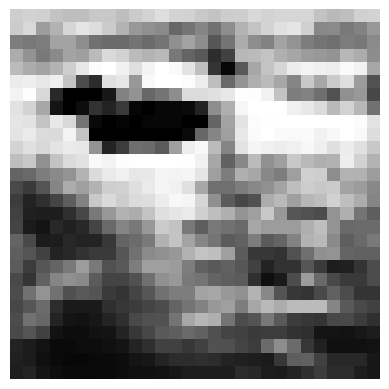

In [165]:
img,label = train_data[1]
image_np = img.squeeze()
print(image_np.shape)
# Plot the image
plt.imshow(image_np,cmap="gray")
plt.axis('off')  # Hide the axes for better visualization
plt.show()

# Functions

## Check GPU

In [170]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda


'NVIDIA GeForce GTX 1650'

In [28]:
#function to clear tensorboard files

def clear_folder(folder_path):
    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"The folder '{folder_path}' does not exist.")
        return
    
    # Iterate through all items in the folder
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        try:
            # Remove directories
            if os.path.isdir(item_path):
                shutil.rmtree(item_path)
            # Remove files
            else:
                os.remove(item_path)
            print(f"Deleted: {item_path}")
        except Exception as e:
            print(f"Failed to delete {item_path}: {e}")
    
    print(f"All contents of the folder '{folder_path}' have been cleared.")
    #location of tensorboard folder
folder="runs/DisplayImage"


class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        """
        Here we define the layers of the network. We create two fully connected layers

        Parameters:
            input_size: the size of the input, in this case 784 (28x28)
            num_classes: the number of classes we want to predict, in this case 2 (0-1)

        """
        super(NN, self).__init__()
        # # Our first linear layer take input_size, in this case 784 nodes to 50
        # # and our second linear layer takes 50 to the num_classes we have, in
        # # this case 10.
        # self.fc1 = nn.Linear(input_size, 50)
        # self.fc2 = nn.Linear(50, num_classes)

        self.flatten = nn.Flatten() #flattens the input tensors
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Linear(50, 2),
            # nn.ReLU(),
            # nn.Linear(512, 2)
        )

    def forward(self, x):
        """
        x here is the mnist images and we run it through the network that we created above.
        Parameters:
            x: mnist images
        Returns:
            out: the output of the network
        """
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(  #same convolution
            in_channels=in_channels,
            out_channels=8,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16, 
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

class NN2(nn.Module):
    def __init__(self, input_size, num_classes):
        """
        Here we define the layers of the network. We create two fully connected layers

        Parameters:
            input_size: the size of the input, in this case 784 (28x28)
            num_classes: the number of classes we want to predict, in this case 10 (0-9)

        """
        super(NN2, self).__init__()
        # Our first linear layer take input_size, in this case 784 nodes to 50
        # and our second linear layer takes 50 to the num_classes we have, in
        # this case 10.
        self.flatten = nn.Flatten() #flattens the input tensors
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        """
        x here is the mnist images and we run it through fc1, fc2 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)

        Parameters:
            x: mnist images

        Returns:
            out: the output of the network
        """
        x=self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    accuracies=[]
    batch_loss=0
    for batch, (input_data, class_cat) in enumerate(tqdm(dataloader)):
        input_data, class_cat = input_data.to(device), class_cat.to(device)

        ## Compute prediction error
        pred = model(input_data)
        class_cat=class_cat.squeeze().long()
        loss = loss_fn(pred, class_cat)

        ## Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        ## calculation running loss
        loss, current = loss.item(), (batch + 1) * len(input_data)


        ##caculating running accuracy
        _, predictions = pred.max(1)
        num_correct = (predictions == class_cat).sum()
        running_train_acc = float(num_correct) / float(input_data.shape[0])
        # print("model Output>>>>>")
        # print(pred)
        # print("predictions>>>")
        # print(predictions)
        # print("num_correct>>>>>")
        # print(num_correct)
        # print("accuracy>>>>")
        # print(running_train_acc)
        # print(data.shape[0])
        # print(input_data.shape[0])
        accuracies.append(running_train_acc)

        ##Plot stuff to tensorboard tensorboard
        global step
        writer.add_scalar("Batch/Training loss",loss,global_step=step)
        writer.add_scalar("Batch/Training Accuracy", running_train_acc, global_step=step)
        # global batch_loss
        # batch_loss.append(loss)
        batch_loss+=loss

        
        step += 1


        #print(f"loss: {loss:>7f} accuracy: {running_train_acc:>5f}  [{current:>5d}/{size:>5d}]")
    
    ## Calculate epoch accuracy
    epoch_accuracy=sum(accuracies)/len(accuracies)

    ## Getting the average epoch loss
    epoch_loss=batch_loss/size
    
    ## Send it to tensorboard
    writer.add_scalars("Epoch/Epoch loss",{'Train':epoch_loss},global_step=epoch)
    writer.add_scalars("Epoch/Epoch Accuracy",{"Train":epoch_accuracy},global_step=epoch)
    

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y=y.squeeze().long()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    writer.add_scalars("Epoch/Epoch loss",{'Test':test_loss},global_step=epoch)
    writer.add_scalars("Epoch/Epoch Accuracy",{"Test":correct},global_step=epoch)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



In [27]:
#basinc testing for the model
model=CNN()
x=torch.randn(20,1,28,28)
print(model(x).shape)

model=NN(input_size=28*28,num_classes=2)
x=torch.randn(20,1,28,28)
print(model(x).shape)

torch.Size([20, 10])
torch.Size([20, 10])


# Fully connected network


In [ ]:
# Hyperparameters
input_size = 28*28
num_classes = 2
learning_rate = 0.001
#batch_size = 64 Note: this was determined when we loaded the data previously
num_epochs = 100

model = NN(input_size=input_size, num_classes=num_classes).to(device)
print(model)
## Setting up training and test function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

##clear tensorboard folder
clear_folder(folder)
writer = SummaryWriter(f"runs/DisplayImage")

#show using dataset on tensorboard
for index, (data,label) in enumerate(train_loader):
    data,label=train_data[index]
    writer.add_image("mnist_images", data,index)

# Visualize model in TensorBoard
example_img, labels = next(iter(train_loader))
#example_img=example_img[0]
writer.add_graph(model,example_img.to(device))
print("Model sent to tensorboard")

step=0
# epoch_loss=[]
for t in range(num_epochs):
    epoch=t
    # batch_loss=[]
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    
    # epoch_loss.append(sum(batch_loss)/len(batch_loss))
    # writer.add_scalar("Epoch Training loss",epoch_loss[t],global_step=t)
    test(test_loader, model, loss_fn)

print("Done!")

NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=2, bias=True)
  )
)
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Train'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Train'
Deleted: runs/DisplayImage\events.out.tfevents.1733871344.DESKTOP-3FC1MTH.29016.125
All contents of the folder 'runs/DisplayImage' have been cleared.
Model sent to tensorboard
Epoch 1
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 95.46it/s]


Test Error: 
 Accuracy: 73.1%, Avg loss: 0.563203 

Epoch 2
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 109.16it/s]


Test Error: 
 Accuracy: 73.1%, Avg loss: 0.552754 

Epoch 3
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 108.77it/s]

Test Error: 
 Accuracy: 73.1%, Avg loss: 0.534799 



Epoch 4
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 112.65it/s]


Test Error: 
 Accuracy: 75.0%, Avg loss: 0.566214 

Epoch 5
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 105.62it/s]

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.541050 



Epoch 6
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 104.19it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.509773 



Epoch 7
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 109.45it/s]

Test Error: 
 Accuracy: 80.8%, Avg loss: 0.512898 



Epoch 8
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 110.30it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.504393 

Epoch 9
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 108.00it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.499212 

Epoch 10
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 111.83it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.504169 

Epoch 11
-------------------------------



100%|██████████| 18/18 [00:00<00:00, 96.89it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.497187 

Epoch 12
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 103.34it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.488681 

Epoch 13
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 108.38it/s]

Test Error: 
 Accuracy: 80.1%, Avg loss: 0.498249 



Epoch 14
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 104.01it/s]

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.538796 



Epoch 15
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 107.23it/s]

Test Error: 
 Accuracy: 80.8%, Avg loss: 0.492598 



Epoch 16
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 99.43it/s]

Test Error: 
 Accuracy: 80.8%, Avg loss: 0.489529 

Epoch 17
-------------------------------



100%|██████████| 18/18 [00:00<00:00, 110.51it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.507975 



Epoch 18
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 107.40it/s]

Test Error: 
 Accuracy: 80.8%, Avg loss: 0.486147 



Epoch 19
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 95.97it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.507458 

Epoch 20
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 102.38it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.484074 

Epoch 21
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 102.26it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.511604 

Epoch 22
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 107.14it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.505525 

Epoch 23
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 110.62it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.481152 

Epoch 24
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 100.59it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.504711 

Epoch 25
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 94.22it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.483202 

Epoch 26
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 107.03it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.487605 

Epoch 27
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 107.01it/s]

Test Error: 
 Accuracy: 80.8%, Avg loss: 0.477609 



Epoch 28
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 100.95it/s]

Test Error: 
 Accuracy: 80.8%, Avg loss: 0.477190 



Epoch 29
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 108.75it/s]

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.473787 



Epoch 30
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 100.24it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.474170 

Epoch 31
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 103.88it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.490721 

Epoch 32
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 109.56it/s]

Test Error: 
 Accuracy: 76.3%, Avg loss: 0.508924 



Epoch 33
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 101.45it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.486733 



Epoch 34
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 114.48it/s]

Test Error: 
 Accuracy: 81.4%, Avg loss: 0.471365 



Epoch 35
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 95.18it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.475088 

Epoch 36
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 107.11it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.493793 

Epoch 37
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 98.53it/s]


Test Error: 
 Accuracy: 76.3%, Avg loss: 0.493857 

Epoch 38
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 108.12it/s]


Test Error: 
 Accuracy: 75.6%, Avg loss: 0.499857 

Epoch 39
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 111.61it/s]

Test Error: 
 Accuracy: 82.7%, Avg loss: 0.483864 



Epoch 40
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 105.86it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.486818 



Epoch 41
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 105.15it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.466285 

Epoch 42
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 98.50it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.479150 

Epoch 43
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 102.17it/s]


Test Error: 
 Accuracy: 75.0%, Avg loss: 0.532689 

Epoch 44
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 107.03it/s]

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.482646 



Epoch 45
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 100.27it/s]

Test Error: 
 Accuracy: 80.8%, Avg loss: 0.480800 



Epoch 46
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 106.70it/s]

Test Error: 
 Accuracy: 75.6%, Avg loss: 0.505386 



Epoch 47
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 93.98it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.472992 

Epoch 48
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 103.11it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.471592 

Epoch 49
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 100.93it/s]


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.462724 

Epoch 50
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 106.97it/s]


Test Error: 
 Accuracy: 82.7%, Avg loss: 0.467893 

Epoch 51
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 102.27it/s]


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.474113 

Epoch 52
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 99.11it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.468296 

Epoch 53
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 105.35it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.465945 



Epoch 54
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 97.54it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.466787 

Epoch 55
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 105.89it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.467097 

Epoch 56
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 99.71it/s] 


Test Error: 
 Accuracy: 82.1%, Avg loss: 0.469830 

Epoch 57
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 87.09it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.467989 

Epoch 58
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 98.92it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.465366 

Epoch 59
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 98.63it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.487830 

Epoch 60
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 90.19it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.467353 

Epoch 61
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 105.52it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.466282 

Epoch 62
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 102.96it/s]


Test Error: 
 Accuracy: 82.7%, Avg loss: 0.463225 

Epoch 63
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 99.16it/s]


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.461119 

Epoch 64
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 106.23it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.471071 

Epoch 65
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 104.27it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.465476 



Epoch 66
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 77.21it/s]


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.471804 

Epoch 67
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 83.92it/s]


Test Error: 
 Accuracy: 77.6%, Avg loss: 0.476919 

Epoch 68
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 105.09it/s]

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.483237 



Epoch 69
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 90.52it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.462450 

Epoch 70
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 90.06it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.467297 

Epoch 71
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 101.98it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.464194 

Epoch 72
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 83.77it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.466100 

Epoch 73
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 97.72it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.462628 

Epoch 74
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 94.51it/s]


Test Error: 
 Accuracy: 77.6%, Avg loss: 0.467688 

Epoch 75
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 83.30it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.462917 

Epoch 76
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 97.49it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.463132 

Epoch 77
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 103.04it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.461150 

Epoch 78
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 85.70it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.456771 

Epoch 79
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 101.24it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.477790 



Epoch 80
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 96.82it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.468875 

Epoch 81
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 95.55it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.457943 

Epoch 82
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 103.84it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.460498 

Epoch 83
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 99.22it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.468518 

Epoch 84
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 95.74it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.469797 

Epoch 85
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 103.65it/s]


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.459493 

Epoch 86
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 97.71it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.473290 

Epoch 87
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 105.90it/s]


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.456080 

Epoch 88
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 102.33it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.459135 

Epoch 89
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 94.83it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.455784 

Epoch 90
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 100.75it/s]

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.471187 



Epoch 91
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 93.96it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.493162 

Epoch 92
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 84.69it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.459277 

Epoch 93
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 104.40it/s]

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.474029 



Epoch 94
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 97.51it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.458058 

Epoch 95
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 97.53it/s]


Test Error: 
 Accuracy: 77.6%, Avg loss: 0.523879 

Epoch 96
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 97.31it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.453113 

Epoch 97
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 97.66it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.483172 

Epoch 98
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 105.46it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.457661 

Epoch 99
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 103.07it/s]


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.460400 

Epoch 100
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 97.27it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.456855 

Done!


# CNN

In [ ]:
# Full implementation

# Hyperparameters
input_size = 28*28
num_classes = 2
learning_rate = 0.005
batch_size = 64
num_epochs = 100

model = CNN().to(device)
print(model)
## Setting up training and test function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

##clear tensorboard folder
clear_folder(folder)
writer = SummaryWriter(f"runs/DisplayImage")

#show using dataset on tensorboard
# for index, (data,label) in enumerate(train_loader):
#     data,label=train_data[index]
#     writer.add_image("mnist_images", data,index)

# Visualize model in TensorBoard
example_img, labels = next(iter(train_loader))
#example_img=example_img[0]
writer.add_graph(model,example_img.to(device))
print("Model sent to tensorboard")

step=0
# epoch_loss=[]
for t in range(num_epochs):
    epoch=t
    # batch_loss=[]
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    
    # epoch_loss.append(sum(batch_loss)/len(batch_loss))
    # writer.add_scalar("Epoch Training loss",epoch_loss[t],global_step=t)
    test(test_loader, model, loss_fn)

print("Done!")

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=2, bias=True)
)
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Train'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Train'
Deleted: runs/DisplayImage\events.out.tfevents.1733872457.DESKTOP-3FC1MTH.29016.163
All contents of the folder 'runs/DisplayImage' have been cleared.

100%|██████████| 18/18 [00:00<00:00, 75.64it/s]


Test Error: 
 Accuracy: 73.7%, Avg loss: 0.670155 

Epoch 2
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.43it/s]


Test Error: 
 Accuracy: 58.3%, Avg loss: 0.678390 

Epoch 3
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.17it/s]


Test Error: 
 Accuracy: 73.1%, Avg loss: 0.629313 

Epoch 4
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.23it/s]


Test Error: 
 Accuracy: 61.5%, Avg loss: 0.666466 

Epoch 5
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.71it/s]


Test Error: 
 Accuracy: 69.9%, Avg loss: 0.600066 

Epoch 6
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.39it/s]


Test Error: 
 Accuracy: 71.2%, Avg loss: 0.588484 

Epoch 7
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 77.47it/s]


Test Error: 
 Accuracy: 70.5%, Avg loss: 0.580231 

Epoch 8
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.17it/s]


Test Error: 
 Accuracy: 46.2%, Avg loss: 0.742621 

Epoch 9
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.91it/s]


Test Error: 
 Accuracy: 75.0%, Avg loss: 0.547495 

Epoch 10
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 74.02it/s]


Test Error: 
 Accuracy: 66.7%, Avg loss: 0.617752 

Epoch 11
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.34it/s]


Test Error: 
 Accuracy: 55.1%, Avg loss: 0.691563 

Epoch 12
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.23it/s]


Test Error: 
 Accuracy: 70.5%, Avg loss: 0.584678 

Epoch 13
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.65it/s]


Test Error: 
 Accuracy: 72.4%, Avg loss: 0.556335 

Epoch 14
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.34it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.497131 

Epoch 15
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.46it/s]


Test Error: 
 Accuracy: 71.8%, Avg loss: 0.558116 

Epoch 16
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 74.56it/s]


Test Error: 
 Accuracy: 66.0%, Avg loss: 0.601421 

Epoch 17
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 73.78it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.493852 

Epoch 18
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.38it/s]


Test Error: 
 Accuracy: 68.6%, Avg loss: 0.589832 

Epoch 19
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.46it/s]


Test Error: 
 Accuracy: 69.2%, Avg loss: 0.587184 

Epoch 20
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.40it/s]


Test Error: 
 Accuracy: 75.6%, Avg loss: 0.503780 

Epoch 21
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 74.34it/s]


Test Error: 
 Accuracy: 73.7%, Avg loss: 0.558361 

Epoch 22
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.03it/s]


Test Error: 
 Accuracy: 74.4%, Avg loss: 0.543953 

Epoch 23
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.57it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.465574 

Epoch 24
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.92it/s]


Test Error: 
 Accuracy: 67.9%, Avg loss: 0.597871 

Epoch 25
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 74.06it/s]


Test Error: 
 Accuracy: 72.4%, Avg loss: 0.560259 

Epoch 26
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 77.56it/s]


Test Error: 
 Accuracy: 71.8%, Avg loss: 0.550583 

Epoch 27
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 74.14it/s]


Test Error: 
 Accuracy: 77.6%, Avg loss: 0.500327 

Epoch 28
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 78.07it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.485214 

Epoch 29
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.83it/s]


Test Error: 
 Accuracy: 72.4%, Avg loss: 0.569587 

Epoch 30
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.80it/s]


Test Error: 
 Accuracy: 72.4%, Avg loss: 0.559599 

Epoch 31
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.23it/s]


Test Error: 
 Accuracy: 76.3%, Avg loss: 0.519503 

Epoch 32
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.82it/s]


Test Error: 
 Accuracy: 76.3%, Avg loss: 0.495873 

Epoch 33
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 73.74it/s]


Test Error: 
 Accuracy: 72.4%, Avg loss: 0.562477 

Epoch 34
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 74.73it/s]


Test Error: 
 Accuracy: 73.7%, Avg loss: 0.564624 

Epoch 35
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 74.12it/s]


Test Error: 
 Accuracy: 71.2%, Avg loss: 0.574060 

Epoch 36
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 73.33it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.458535 

Epoch 37
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 74.85it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.489357 

Epoch 38
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 73.99it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.507919 

Epoch 39
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 74.23it/s]


Test Error: 
 Accuracy: 71.2%, Avg loss: 0.538057 

Epoch 40
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.06it/s]


Test Error: 
 Accuracy: 76.3%, Avg loss: 0.514061 

Epoch 41
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 74.58it/s]


Test Error: 
 Accuracy: 73.1%, Avg loss: 0.534169 

Epoch 42
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.94it/s]


Test Error: 
 Accuracy: 73.7%, Avg loss: 0.521687 

Epoch 43
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.94it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.482720 

Epoch 44
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.24it/s]


Test Error: 
 Accuracy: 68.6%, Avg loss: 0.560910 

Epoch 45
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 73.19it/s]


Test Error: 
 Accuracy: 73.7%, Avg loss: 0.533707 

Epoch 46
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 74.36it/s]


Test Error: 
 Accuracy: 76.3%, Avg loss: 0.518513 

Epoch 47
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.29it/s]


Test Error: 
 Accuracy: 72.4%, Avg loss: 0.542704 

Epoch 48
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 73.42it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.473625 

Epoch 49
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.27it/s]


Test Error: 
 Accuracy: 64.7%, Avg loss: 0.612690 

Epoch 50
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.96it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.500503 

Epoch 51
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 73.23it/s]


Test Error: 
 Accuracy: 69.2%, Avg loss: 0.589843 

Epoch 52
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.21it/s]


Test Error: 
 Accuracy: 71.2%, Avg loss: 0.554419 

Epoch 53
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.72it/s]


Test Error: 
 Accuracy: 72.4%, Avg loss: 0.543021 

Epoch 54
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.27it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.473746 

Epoch 55
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.36it/s]


Test Error: 
 Accuracy: 73.7%, Avg loss: 0.536447 

Epoch 56
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.58it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.483402 

Epoch 57
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.92it/s]


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.453410 

Epoch 58
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.63it/s]


Test Error: 
 Accuracy: 74.4%, Avg loss: 0.519553 

Epoch 59
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 73.84it/s]


Test Error: 
 Accuracy: 77.6%, Avg loss: 0.479295 

Epoch 60
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.24it/s]


Test Error: 
 Accuracy: 71.8%, Avg loss: 0.557822 

Epoch 61
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 73.06it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.464903 

Epoch 62
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 78.91it/s]


Test Error: 
 Accuracy: 72.4%, Avg loss: 0.541019 

Epoch 63
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 77.92it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.490308 

Epoch 64
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 77.94it/s]


Test Error: 
 Accuracy: 73.7%, Avg loss: 0.512421 

Epoch 65
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.84it/s]


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.455279 

Epoch 66
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 77.25it/s]


Test Error: 
 Accuracy: 82.7%, Avg loss: 0.451468 

Epoch 67
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.08it/s]


Test Error: 
 Accuracy: 74.4%, Avg loss: 0.534241 

Epoch 68
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.87it/s]


Test Error: 
 Accuracy: 71.8%, Avg loss: 0.552661 

Epoch 69
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.38it/s]


Test Error: 
 Accuracy: 73.1%, Avg loss: 0.529705 

Epoch 70
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 78.36it/s]


Test Error: 
 Accuracy: 69.2%, Avg loss: 0.575091 

Epoch 71
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.48it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.466968 

Epoch 72
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 73.86it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.456274 

Epoch 73
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.66it/s]


Test Error: 
 Accuracy: 69.2%, Avg loss: 0.582350 

Epoch 74
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.06it/s]


Test Error: 
 Accuracy: 75.6%, Avg loss: 0.507055 

Epoch 75
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.40it/s]


Test Error: 
 Accuracy: 67.9%, Avg loss: 0.617389 

Epoch 76
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.80it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.457555 

Epoch 77
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 74.10it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.509073 

Epoch 78
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.69it/s]


Test Error: 
 Accuracy: 75.6%, Avg loss: 0.525313 

Epoch 79
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.26it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.447285 

Epoch 80
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.09it/s]


Test Error: 
 Accuracy: 69.9%, Avg loss: 0.548209 

Epoch 81
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.96it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.477899 

Epoch 82
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.93it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.491424 

Epoch 83
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.17it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.442894 

Epoch 84
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.53it/s]


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.473217 

Epoch 85
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 71.97it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.477719 

Epoch 86
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 76.49it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.487313 

Epoch 87
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 79.40it/s]


Test Error: 
 Accuracy: 77.6%, Avg loss: 0.500238 

Epoch 88
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 73.71it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.434273 

Epoch 89
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 73.45it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.497558 

Epoch 90
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 77.52it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.474754 

Epoch 91
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.14it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.496028 

Epoch 92
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.30it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.497942 

Epoch 93
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 70.95it/s]


Test Error: 
 Accuracy: 75.6%, Avg loss: 0.491430 

Epoch 94
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 73.12it/s]


Test Error: 
 Accuracy: 70.5%, Avg loss: 0.568441 

Epoch 95
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.26it/s]


Test Error: 
 Accuracy: 76.3%, Avg loss: 0.506480 

Epoch 96
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 74.63it/s]


Test Error: 
 Accuracy: 75.0%, Avg loss: 0.523484 

Epoch 97
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.01it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.457566 

Epoch 98
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.94it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.436952 

Epoch 99
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 72.28it/s]


Test Error: 
 Accuracy: 75.0%, Avg loss: 0.504841 

Epoch 100
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 75.20it/s]

Test Error: 
 Accuracy: 81.4%, Avg loss: 0.430495 

Done!


# Pretained Model

In [243]:
transform = transforms.Compose([
    transforms.RandomAdjustSharpness(p=1,sharpness_factor=1.1),
    transforms.RandomEqualize(p=0.3),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))  # Mean and standard deviation for grayscale images
])

batch_size=32
#loading train,val,test into variables
train_data=medmnist.BreastMNIST(split="train",transform=transform)
val_data=medmnist.BreastMNIST(split="val",transform=transforms.ToTensor())
test_data=medmnist.BreastMNIST(split="test",transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)





# Hyperparameters
input_size = 28*28
num_classes = 2
learning_rate = 0.01
num_epochs = 100


model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

#Freeze the model
# for param in model.parameters():
#     param.requires_grad=False

model.conv1 = nn.Conv2d(
    in_channels=1,  # Change to 1 channel for grayscale
    out_channels=64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)

# Optionally copy pretrained weights and average across RGB channels
with torch.no_grad():
    pretrained_weights = model.conv1.weight  # Original weights for RGB
    model.conv1.weight.copy_(torch.mean(pretrained_weights, dim=1, keepdim=True))

# Adjust the fully connected layer to match the number of output classes
num_classes = 2  # Example: MNIST has 10 classes
model.fc = nn.Sequential(
            nn.Linear(512, 100),
            nn.ReLU(),
            nn.Linear(100, 2),
)
model.avgpool = nn.Identity()

print(model)
# Move model to the correct device
model = model.to(device)

##clear tensorboard folder
clear_folder(folder)
writer = SummaryWriter(f"runs/DisplayImage")

#show using dataset on tensorboard
for index, (data,label) in enumerate(train_loader):
    data,label=train_data[index]
    writer.add_image("mnist_images", data,index)

# Visualize model in TensorBoard
example_img, labels = next(iter(train_loader))
#example_img=example_img[0]
writer.add_graph(model,example_img.to(device))
print("Model sent to tensorboard")


step=0
# epoch_loss=[]
for t in range(num_epochs):
    epoch=t
    # batch_loss=[]
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    
    # epoch_loss.append(sum(batch_loss)/len(batch_loss))
    # writer.add_scalar("Epoch Training loss",epoch_loss[t],global_step=t)
    test(test_loader, model, loss_fn)

print("Done!")

Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 18/18 [00:00<00:00, 25.04it/s]


Test Error: 
 Accuracy: 72.4%, Avg loss: 0.644640 

Epoch 2
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.98it/s]


Test Error: 
 Accuracy: 70.5%, Avg loss: 0.651748 

Epoch 3
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.11it/s]


Test Error: 
 Accuracy: 67.9%, Avg loss: 0.649421 

Epoch 4
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.71it/s]


Test Error: 
 Accuracy: 57.1%, Avg loss: 0.695327 

Epoch 5
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.79it/s]


Test Error: 
 Accuracy: 48.7%, Avg loss: 0.716137 

Epoch 6
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.55it/s]


Test Error: 
 Accuracy: 52.6%, Avg loss: 0.700917 

Epoch 7
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.37it/s]


Test Error: 
 Accuracy: 46.8%, Avg loss: 0.706106 

Epoch 8
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.95it/s]


Test Error: 
 Accuracy: 48.7%, Avg loss: 0.725769 

Epoch 9
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.87it/s]


Test Error: 
 Accuracy: 49.4%, Avg loss: 0.712307 

Epoch 10
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.78it/s]


Test Error: 
 Accuracy: 51.9%, Avg loss: 0.715142 

Epoch 11
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.89it/s]


Test Error: 
 Accuracy: 50.6%, Avg loss: 0.702545 

Epoch 12
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.80it/s]


Test Error: 
 Accuracy: 48.1%, Avg loss: 0.704380 

Epoch 13
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.58it/s]


Test Error: 
 Accuracy: 50.0%, Avg loss: 0.709851 

Epoch 14
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.33it/s]


Test Error: 
 Accuracy: 50.0%, Avg loss: 0.720247 

Epoch 15
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.05it/s]


Test Error: 
 Accuracy: 49.4%, Avg loss: 0.712609 

Epoch 16
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.09it/s]


Test Error: 
 Accuracy: 52.6%, Avg loss: 0.697103 

Epoch 17
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 32.86it/s]


Test Error: 
 Accuracy: 55.1%, Avg loss: 0.694686 

Epoch 18
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.06it/s]


Test Error: 
 Accuracy: 49.4%, Avg loss: 0.716898 

Epoch 19
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.44it/s]


Test Error: 
 Accuracy: 48.7%, Avg loss: 0.700749 

Epoch 20
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.82it/s]


Test Error: 
 Accuracy: 50.6%, Avg loss: 0.718006 

Epoch 21
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.74it/s]


Test Error: 
 Accuracy: 48.7%, Avg loss: 0.701603 

Epoch 22
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.39it/s]


Test Error: 
 Accuracy: 54.5%, Avg loss: 0.707362 

Epoch 23
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.32it/s]


Test Error: 
 Accuracy: 51.9%, Avg loss: 0.697764 

Epoch 24
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.68it/s]


Test Error: 
 Accuracy: 46.8%, Avg loss: 0.704699 

Epoch 25
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.65it/s]


Test Error: 
 Accuracy: 50.6%, Avg loss: 0.710654 

Epoch 26
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.79it/s]


Test Error: 
 Accuracy: 48.7%, Avg loss: 0.710887 

Epoch 27
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.46it/s]


Test Error: 
 Accuracy: 53.8%, Avg loss: 0.698045 

Epoch 28
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.10it/s]


Test Error: 
 Accuracy: 50.6%, Avg loss: 0.693948 

Epoch 29
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.60it/s]


Test Error: 
 Accuracy: 51.3%, Avg loss: 0.688887 

Epoch 30
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.85it/s]


Test Error: 
 Accuracy: 50.6%, Avg loss: 0.702821 

Epoch 31
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.79it/s]


Test Error: 
 Accuracy: 48.1%, Avg loss: 0.712638 

Epoch 32
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.33it/s]


Test Error: 
 Accuracy: 44.2%, Avg loss: 0.705914 

Epoch 33
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.95it/s]


Test Error: 
 Accuracy: 47.4%, Avg loss: 0.718224 

Epoch 34
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 32.86it/s]


Test Error: 
 Accuracy: 50.0%, Avg loss: 0.707449 

Epoch 35
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.66it/s]


Test Error: 
 Accuracy: 49.4%, Avg loss: 0.709258 

Epoch 36
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.49it/s]


Test Error: 
 Accuracy: 46.8%, Avg loss: 0.719647 

Epoch 37
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.29it/s]


Test Error: 
 Accuracy: 47.4%, Avg loss: 0.722543 

Epoch 38
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.09it/s]


Test Error: 
 Accuracy: 44.2%, Avg loss: 0.720465 

Epoch 39
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.09it/s]


Test Error: 
 Accuracy: 48.1%, Avg loss: 0.704402 

Epoch 40
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.83it/s]


Test Error: 
 Accuracy: 49.4%, Avg loss: 0.729960 

Epoch 41
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.96it/s]


Test Error: 
 Accuracy: 52.6%, Avg loss: 0.695546 

Epoch 42
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.23it/s]


Test Error: 
 Accuracy: 50.0%, Avg loss: 0.702166 

Epoch 43
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.59it/s]


Test Error: 
 Accuracy: 49.4%, Avg loss: 0.707466 

Epoch 44
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.44it/s]


Test Error: 
 Accuracy: 54.5%, Avg loss: 0.706964 

Epoch 45
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.56it/s]


Test Error: 
 Accuracy: 48.7%, Avg loss: 0.714455 

Epoch 46
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.17it/s]


Test Error: 
 Accuracy: 48.1%, Avg loss: 0.706063 

Epoch 47
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.59it/s]


Test Error: 
 Accuracy: 56.4%, Avg loss: 0.690316 

Epoch 48
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.09it/s]


Test Error: 
 Accuracy: 50.6%, Avg loss: 0.701205 

Epoch 49
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.91it/s]


Test Error: 
 Accuracy: 50.0%, Avg loss: 0.712974 

Epoch 50
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.77it/s]


Test Error: 
 Accuracy: 50.6%, Avg loss: 0.704910 

Epoch 51
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.18it/s]


Test Error: 
 Accuracy: 47.4%, Avg loss: 0.700399 

Epoch 52
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.76it/s]


Test Error: 
 Accuracy: 51.9%, Avg loss: 0.698741 

Epoch 53
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.90it/s]


Test Error: 
 Accuracy: 53.2%, Avg loss: 0.698579 

Epoch 54
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.54it/s]


Test Error: 
 Accuracy: 50.6%, Avg loss: 0.706579 

Epoch 55
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.11it/s]


Test Error: 
 Accuracy: 53.8%, Avg loss: 0.684300 

Epoch 56
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.70it/s]


Test Error: 
 Accuracy: 54.5%, Avg loss: 0.696438 

Epoch 57
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.04it/s]


Test Error: 
 Accuracy: 46.8%, Avg loss: 0.707033 

Epoch 58
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.28it/s]


Test Error: 
 Accuracy: 46.8%, Avg loss: 0.706156 

Epoch 59
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.67it/s]


Test Error: 
 Accuracy: 47.4%, Avg loss: 0.716692 

Epoch 60
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.13it/s]


Test Error: 
 Accuracy: 48.7%, Avg loss: 0.706538 

Epoch 61
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 32.64it/s]


Test Error: 
 Accuracy: 48.1%, Avg loss: 0.708787 

Epoch 62
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 32.80it/s]


Test Error: 
 Accuracy: 50.0%, Avg loss: 0.710011 

Epoch 63
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.18it/s]


Test Error: 
 Accuracy: 46.2%, Avg loss: 0.708144 

Epoch 64
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 30.95it/s]


Test Error: 
 Accuracy: 50.6%, Avg loss: 0.715087 

Epoch 65
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 32.54it/s]


Test Error: 
 Accuracy: 51.3%, Avg loss: 0.707772 

Epoch 66
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.07it/s]


Test Error: 
 Accuracy: 48.7%, Avg loss: 0.716460 

Epoch 67
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.82it/s]


Test Error: 
 Accuracy: 51.3%, Avg loss: 0.701956 

Epoch 68
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.55it/s]


Test Error: 
 Accuracy: 52.6%, Avg loss: 0.700572 

Epoch 69
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.33it/s]


Test Error: 
 Accuracy: 50.0%, Avg loss: 0.717140 

Epoch 70
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.02it/s]


Test Error: 
 Accuracy: 48.7%, Avg loss: 0.717827 

Epoch 71
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.20it/s]


Test Error: 
 Accuracy: 53.8%, Avg loss: 0.714152 

Epoch 72
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.82it/s]


Test Error: 
 Accuracy: 51.3%, Avg loss: 0.701939 

Epoch 73
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.23it/s]


Test Error: 
 Accuracy: 48.1%, Avg loss: 0.725157 

Epoch 74
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 32.66it/s]


Test Error: 
 Accuracy: 49.4%, Avg loss: 0.705305 

Epoch 75
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.08it/s]


Test Error: 
 Accuracy: 51.3%, Avg loss: 0.704054 

Epoch 76
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.32it/s]


Test Error: 
 Accuracy: 51.3%, Avg loss: 0.708720 

Epoch 77
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.53it/s]


Test Error: 
 Accuracy: 50.6%, Avg loss: 0.709089 

Epoch 78
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.13it/s]


Test Error: 
 Accuracy: 52.6%, Avg loss: 0.712599 

Epoch 79
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.17it/s]


Test Error: 
 Accuracy: 51.9%, Avg loss: 0.699442 

Epoch 80
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.03it/s]


Test Error: 
 Accuracy: 50.6%, Avg loss: 0.707880 

Epoch 81
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.54it/s]


Test Error: 
 Accuracy: 48.1%, Avg loss: 0.712598 

Epoch 82
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.89it/s]


Test Error: 
 Accuracy: 49.4%, Avg loss: 0.719217 

Epoch 83
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.44it/s]


Test Error: 
 Accuracy: 47.4%, Avg loss: 0.713955 

Epoch 84
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.40it/s]


Test Error: 
 Accuracy: 54.5%, Avg loss: 0.696596 

Epoch 85
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.23it/s]


Test Error: 
 Accuracy: 46.8%, Avg loss: 0.712627 

Epoch 86
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.48it/s]


Test Error: 
 Accuracy: 55.1%, Avg loss: 0.695460 

Epoch 87
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.13it/s]


Test Error: 
 Accuracy: 50.6%, Avg loss: 0.702898 

Epoch 88
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.37it/s]


Test Error: 
 Accuracy: 47.4%, Avg loss: 0.713226 

Epoch 89
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.77it/s]


Test Error: 
 Accuracy: 51.9%, Avg loss: 0.705530 

Epoch 90
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.91it/s]


Test Error: 
 Accuracy: 55.1%, Avg loss: 0.687169 

Epoch 91
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.98it/s]


Test Error: 
 Accuracy: 46.8%, Avg loss: 0.706388 

Epoch 92
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.30it/s]


Test Error: 
 Accuracy: 48.7%, Avg loss: 0.704531 

Epoch 93
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.88it/s]


Test Error: 
 Accuracy: 48.7%, Avg loss: 0.715535 

Epoch 94
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.99it/s]


Test Error: 
 Accuracy: 53.2%, Avg loss: 0.696138 

Epoch 95
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.83it/s]


Test Error: 
 Accuracy: 48.1%, Avg loss: 0.723203 

Epoch 96
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.82it/s]


Test Error: 
 Accuracy: 43.6%, Avg loss: 0.710509 

Epoch 97
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 35.13it/s]


Test Error: 
 Accuracy: 49.4%, Avg loss: 0.713097 

Epoch 98
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.95it/s]


Test Error: 
 Accuracy: 49.4%, Avg loss: 0.717923 

Epoch 99
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 34.87it/s]


Test Error: 
 Accuracy: 50.6%, Avg loss: 0.704773 

Epoch 100
-------------------------------


100%|██████████| 18/18 [00:00<00:00, 33.96it/s]


Test Error: 
 Accuracy: 53.8%, Avg loss: 0.696541 

Done!
